In [1]:
from keras.datasets import boston_housing
#from keras import models
#from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [4]:
# Normalize data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [7]:
# Functional model spec

def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu',
                            input_shape=(train_data.shape[1],)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [8]:
# 4 fold cross validation

k=4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=1, verbose=0)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
np.mean(all_scores)

2.4786274

In [11]:
# Run more epochs and log validation score per epoch

num_epochs = 500 
all_mae_histories = [] 
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( 
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0) 
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

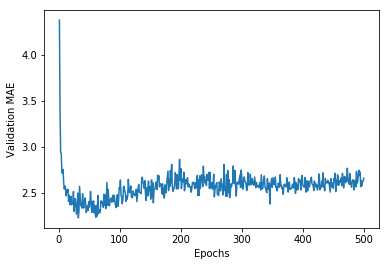

In [17]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [18]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        return smoothed_points

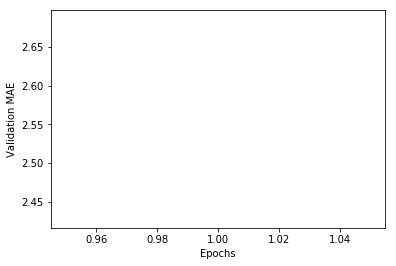

In [19]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [20]:
# Get a fresh, compiled model.
model = build_model()

# Train on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=90, batch_size=8, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/sample - loss: 17.5403 - mean_absolute_error: 2.8514


In [21]:
test_mae_score

2.8514283